In [1]:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageOps, ImageFilter, ImageChops
import numpy as np
import os

In [2]:
def apply_stamp_edges(image, edge_radius=20, perforation_radius=5, perforation_repetition=15, blur_radius=2, outline_width = 10) -> Image:
    """
    Apply a postage stamp edge effect to the given image with sharper edges.

    Parameters:
    - image: A PIL Image object to apply the stamp edges to.
    - edge_radius: Radius of the curved corners of the stamp.
    - perforation_radius: Radius of the perforations along the edge.
    - perforation_repetition: Distance between perforation centers.
    - blur_radius: The radius of the Gaussian blur to apply for edge smoothing. Lower values result in sharper edges.

    Returns:
    - A new PIL Image object with the postage stamp edge effect applied.
    """
    size = image.size
    mask = Image.new('L', size, 0)
    draw = ImageDraw.Draw(mask)
    draw.rectangle([0, 0, *size], fill=255)

    width, height = size
    x_steps = list(range(0, width, perforation_repetition)) + [width-1]
    y_steps = list(range(0, height, perforation_repetition)) + [height-1]
    for x in x_steps:
        for y in y_steps:
            if x == 0 or x == width-1 or y == 0 or y == height-1:
                draw.ellipse((x-perforation_radius, y-perforation_radius, x+perforation_radius, y+perforation_radius), outline='black', fill=0)
                

    mask = mask.filter(ImageFilter.GaussianBlur(blur_radius))
    mask = ImageOps.expand(mask, border=edge_radius, fill=0)
    mask = ImageOps.fit(mask, size, centering=(0.5, 0.5))
    mask = mask.filter(ImageFilter.GaussianBlur(blur_radius))

    result = Image.composite(image, Image.new('RGB', image.size, 'white'), mask)

    return result

def make_personal_stamp(my_img:Image, official_img:Image):
    W, H = official_img.size
    crop_factor = 10
    my_img = my_img.resize((W, H))
    my_img = my_img.crop((
        W/crop_factor,
        H/crop_factor,
        W-(W/crop_factor),
        H-(H/crop_factor)
    ))
    my_img = my_img.rotate(-90)
    my_img = apply_stamp_edges(my_img, edge_radius=crop_factor, blur_radius=1)
    return my_img

def remove_white_background(image, tolerance=10):
    """
    Remove white areas from an image's background, setting them to transparent,
    and stop when encountering non-white content.

    Parameters:
    - image_path: Path to the image file.
    - tolerance: Tolerance for considering a pixel as white.

    Returns:
    - A PIL Image object with white background areas set to transparent.
    """
    # Load the image and convert to RGBA for transparency support
    image = image.convert("RGBA")
    data = np.array(image)

    # Get image dimensions
    rows, cols, _ = data.shape

    # Define white threshold in terms of RGB
    white_threshold = 255 - tolerance

    # Prepare a visited array to mark processed pixels
    visited = np.zeros((rows, cols), dtype=bool)

    # Define a function to check if a pixel is white
    def is_white(x, y):
        return all(data[x, y, :3] > white_threshold) and not visited[x, y]

    # Flood fill algorithm to find and set white areas to transparent
    def flood_fill(x, y):
        # Stack for pixels to process
        stack = [(x, y)]

        while stack:
            x, y = stack.pop()
            if not visited[x, y] and is_white(x, y):
                visited[x, y] = True
                data[x, y, 3] = 0  # Set alpha to 0 for transparency
                # Check neighbors (4-connectivity)
                if x > 0:
                    stack.append((x - 1, y))
                if x < rows - 1:
                    stack.append((x + 1, y))
                if y > 0:
                    stack.append((x, y - 1))
                if y < cols - 1:
                    stack.append((x, y + 1))

    # Apply flood fill from borders
    for row in range(rows):
        if is_white(row, 0): flood_fill(row, 0)
        if is_white(row, cols - 1): flood_fill(row, cols - 1)
    for col in range(cols):
        if is_white(0, col): flood_fill(0, col)
        if is_white(rows - 1, col): flood_fill(rows - 1, col)

    # Return modified image
    return Image.fromarray(data)

def remove_background_and_blur_edges(image, tolerance=10, blur_radius=0.5):
    """
    Remove the background of an image, making it transparent, and apply a light Gaussian blur around the content edges.

    Parameters:
    - image_path: Path to the image file.
    - tolerance: Tolerance for distinguishing between background and content.
    - blur_radius: Radius of the Gaussian blur to apply around the edges.

    Returns:
    - A PIL Image object with the background removed and edges blurred.
    """
    # Load the image
    image = image.convert("RGBA")
    
    # Make the background transparent
    image = remove_white_background(image, tolerance=tolerance)
    
    # Apply Gaussian blur to the whole image
    blurred_image = image.filter(ImageFilter.GaussianBlur(blur_radius))
    
    # Extract the alpha channel from the original image
    alpha = image.split()[-1]
    
    # Create an edge mask from the alpha channel by finding areas with partial transparency
    edge_mask = alpha.point(lambda p: 255 if p > 0 and p < 255 else 0).filter(ImageFilter.GaussianBlur(blur_radius))
    
    # Combine the blurred image with the original based on the edge mask
    final_image = ImageChops.composite(image, blurred_image, edge_mask)

    return final_image

def add_stamp_to_official_img(official_img, stamp, offset=(0, 0)):
    """
    Overlay an image on the top right corner of another image.

    Parameters:
    - main_image_path: Path to the main image.
    - overlay_image_path: Path to the image to be overlaid.
    - offset: A tuple (x, y) specifying the offset from the top right corner.

    Returns:
    - The main image with the overlay image applied.
    """

    # Calculate the position for the overlay
    main_width, main_height = official_img.size
    stamp = stamp.resize((main_width//3, main_height//3))
    overlay_width, overlay_height = stamp.size

    position = (main_width - overlay_width - offset[0], offset[1])

    # Overlay the image
    # Check if the overlay image has an alpha channel
    if stamp.mode == 'RGBA':
        # The overlay image has transparency, use its alpha channel as the mask
        official_img.paste(stamp, position, stamp)
    else:
        # The overlay image does not have transparency, paste directly
        official_img.paste(stamp, position)

    return official_img

def crop_to_content(image, padding=15):
    """
    Crop an image with a mostly transparent background tightly around its non-transparent content.

    Parameters:
    - image_path: Path to the image file.
    - padding: Padding around the content to include in the crop, in pixels.

    Returns:
    - A PIL Image object of the cropped area.
    """
    
    # Get the bounding box of the non-transparent part of the image
    bbox = image.getbbox()
    
    # If the image is completely transparent, return the original image
    if not bbox:
        return image

    # Calculate the new bounding box with padding
    left, upper, right, lower = bbox
    width, height = image.size
    new_bbox = [
        max(left - padding, 0),
        max(upper - padding, 0),
        min(right + padding, width),
        min(lower + padding, height)
    ]

    # Crop the image according to the new bounding box
    cropped_image = image.crop(new_bbox)

    return cropped_image


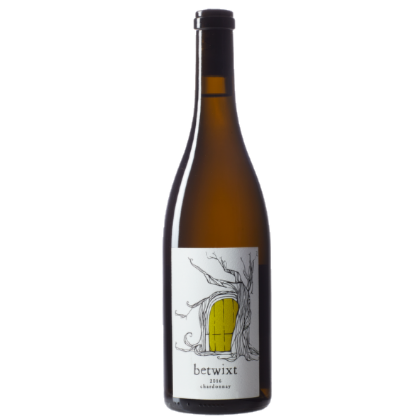

In [3]:
official_img = Image.open('./public/images/all_wines_official/betwixt.png')
official_img = remove_background_and_blur_edges(official_img)
display(official_img)

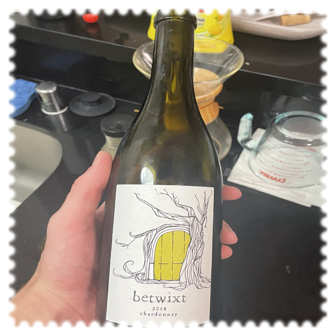

In [4]:
my_img = Image.open('./public/images/all_wines_personal/betwixt.jpg')
my_img = make_personal_stamp(my_img, official_img)
my_img = remove_background_and_blur_edges(my_img, blur_radius=0.2)#make_background_transparent(my_img)
display(my_img)

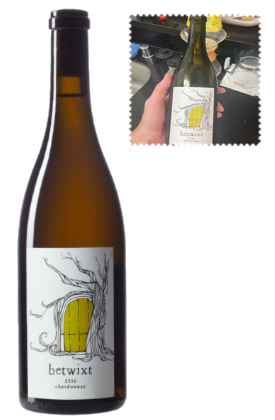

In [5]:
stamped_official_img = add_stamp_to_official_img(official_img, my_img, offset=(10,10))
stamped_official_img = crop_to_content(stamped_official_img)
display(stamped_official_img)

In [6]:
def pad_images_to_match_aspect_ratio(image, padding_color=(255, 255, 255, 0)):
    """
    Pad a list of images so that their aspect ratios match that of a reference image,
    while maintaining their original aspect ratios.

    Parameters:
    - reference_image_path: Path to the reference image file whose aspect ratio is to be matched.
    - image_paths: A list of paths to the images that need to be padded.
    - padding_color: The color used for padding, default is transparent.

    Returns:
    - A list of PIL Image objects of the padded images.
    """
    # Load the reference image and calculate its aspect ratio
    reference_image = Image.open('./public/images/all_wines_official/betwixt.png')
    ref_width, ref_height = reference_image.size
    reference_aspect_ratio = ref_width / ref_height

    image = image.convert("RGBA")
    img_width, img_height = image.size
    if img_width > img_height and img_width > 600:
        divisor = 600/img_width
        image = image.resize((600, int(divisor*img_height)))
    elif img_height > img_width and img_height > 600:
        divisor = 600/img_height
        image = image.resize((int(divisor*img_width), 600))
    img_width, img_height = image.size

    # Calculate the new dimensions based on the reference aspect ratio
    if img_width / img_height > reference_aspect_ratio:
        # Image is wider than reference
        new_height = int(img_width / reference_aspect_ratio)
        new_width = img_width
    else:
        # Image is taller than reference
        new_width = int(img_height * reference_aspect_ratio)
        new_height = img_height

    # Create a new image with the calculated dimensions and fill with the padding color
    padded_image = Image.new("RGBA", (new_width, new_height), padding_color)
    
    # Calculate the position to paste the original image onto the padded image
    paste_x = (new_width - img_width) // 2
    paste_y = (new_height - img_height) // 2
    padded_image.paste(image, (paste_x, paste_y), image)

    return padded_image

In [7]:
def get_stamped_img(official_img, my_img):
    official_img = pad_images_to_match_aspect_ratio(official_img)
    official_img = remove_background_and_blur_edges(official_img)
    my_img = make_personal_stamp(my_img, official_img)
    my_img = remove_background_and_blur_edges(my_img, blur_radius=0.2)
    stamped_official_img = add_stamp_to_official_img(official_img, my_img, offset=(10,10))
    stamped_official_img = crop_to_content(stamped_official_img)
    return stamped_official_img

In [10]:
official_dir = './public/images/all_wines_official'
my_dir = './public/images/all_wines_personal'
stamped_dir = './public/images/all_stamped_wines'
for official_img_name in os.listdir(official_dir):
    print(official_img_name)
    official_img = Image.open(os.path.join(official_dir, official_img_name))
    official_img_name_noext = official_img_name[:official_img_name.rfind('.')]
    my_dir_listed = os.listdir(my_dir)
    matching_path_num = [img[:img.rfind('.')] for img in my_dir_listed].index(official_img_name_noext)
    my_img_name = my_dir_listed[matching_path_num]
    print(my_img_name)
    my_img = Image.open(os.path.join(my_dir, my_img_name))
    stamped_img = get_stamped_img(official_img, my_img)
    os.makedirs(stamped_dir, exist_ok=True)
    stamped_img.save(os.path.join(stamped_dir, official_img_name_noext+'.png'))

cellars33_zin.png
cellars33_zin.jpg
westerly_malbec.png
westerly_malbec.jpg
betwixt.png
betwixt.jpg
moroso.png
moroso.jpg
starsdust.png
starsdust.jpg
josh.png
josh.jpg
kalinero.png
kalinero.jpg
cellars33_chard.png
cellars33_chard.jpg
menage.png
menage.jpg
andis.png
andis.jpg
hostenspicant.jpg
hostenspicant.jpg
lucasandlewellen_pinot.png
lucasandlewellen_pinot.jpg
